# A Methodology for Machine Learning Analysis of Space-Exposed Murine Liver (Transcriptomics)

The purpose of this analysis notebook is to provide the necessary code to perform our analysis and generate figures necessary for our the publication *Spaced Out Data No More: Genomic Harmonization Meets Machine Learning in Murine Livers*. 

- Notebook Author: Hari Ilangovan


|Version History | Date | 
|----------| ----- |
|v0| 12/10/2022 | 
|v1 | 11/2/2023 | 


Publication Authorship:
- Hari Ilangovan<sup>1</sup>
- Prachi Kothiyal<sup>2</sup>
- Katherine A. Hoadley<sup>3</sup>
- Robin Elgart<sup>4</sup>
- Greg Eley<sup>2</sup>
- Parastou Eslami<sup>5</sup>

<sup>1</sup> Science Applications International Corporation (SAIC), Reston, VA 20190, USA
<sup>2</sup>Scimentis LLC, Statham, GA 30666, USA
<sup>3</sup>Department of Genetics, Computational Medicine Program, Lineberger Comprehensive Cancer Center, University of North Caroline at Chapel Hill, Chapel Hill, NC 27599, USA
<sup>4</sup>University of Houston, Houston, TX 77204, USA
<sup>5</sup>Universal Artificial Intelligence Inc, Boston, MA 02130, USA

# Table of Contents

- [Library and Open-Source Package Loading](#Library-Loading)
- [Loading Study Counts and Metadata](#Loading-Study-Counts-and-Metadata)
- [Filtering for Spaceflight Contrast & Removing Technical Replicates](#Filtering-Counts-Matrices)
- [Loading Protein Coding Gene Set](#Prefiltering-for-Protein-Coding-Genes)
- [Gene count tail distribution](#Tails-of-Gene-Sample-Counts-Distribution)
- [Gene-Sample Counts Distribution](#Gene-Sample-Counts-Distribution)

## Library Loading

[Back to Top](#Table-of-Contents)

In [1]:
%matplotlib inline

# imports
import pandas as pd
import numpy as np
from pathlib import PurePath, Path
import json

In [2]:
# plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style="white", palette=None)

In [3]:
# Load rcParams from JSON file
with open('sns_style.json', 'r') as f:
    custom_rcparams = json.load(f)

# Update Matplotlib rcParams
plt.rcParams.update(custom_rcparams)

In [4]:
%cd ./../scripts/

/home/hilangov/grc_gitlab/trrac-genelab-liver-manuscript/scripts


In [5]:
generate_flat_files = False

## Loading Study Counts and Metadata

[Back to Top](#Table-of-Contents)

In [6]:
# set data paths
data_dict = {
    'datasets': ['47','168_rr1','168_rr3', '242','245','379']
}
p = Path.cwd()
p_source_data = p / 'data' / 'raw_counts'
p_metadata = p / 'data' / 'single_study_metadata'

for d in data_dict['datasets']:
    data_dict[d] = {'df':pd.read_csv(p_source_data / (d + '.csv'), index_col=0).transpose(),
                    'metadata_df': pd.read_csv(p_metadata / (d + '.txt'), sep='\t')}
    print(d, data_dict[d]['df'].shape, data_dict[d]['metadata_df'].shape)

47 (9, 55536) (9, 51)
168_rr1 (40, 55628) (20, 55)
168_rr3 (12, 55628) (12, 55)
242 (23, 55628) (23, 54)
245 (59, 55628) (59, 66)
379 (141, 55579) (141, 57)


In [7]:
concat_df = pd.concat(data_dict[d]['df'] for d in data_dict['datasets'])
metadata_df = pd.concat(data_dict[d]['metadata_df'] for d in data_dict['datasets'])

In [8]:
metadata_cols = ['Source Name', 
                 'Factor Value[Spaceflight]', 
                 'Factor Value[Dissection Condition]', 
                 'Sample Name']
metadata_df = metadata_df.loc[:, metadata_cols]

## Filtering Counts Matrices

[Back to Top](#Table-of-Contents)

In [9]:
# metadata_df
remove =['RR1_FLT_M22','RR1_FLT_M21','RR1_GC_M32','RR1_GC_M31'] # 'RR1_FLT_M29','RR1_GC_M35'
metadata_df = metadata_df.loc[~metadata_df['Factor Value[Spaceflight]'].isin(['Vivarium Control', 'Basal Control']),:]
metadata_df = metadata_df.loc[~metadata_df['Source Name'].isin(remove),:]
remove = ['Mmus_C57-6J_LVR_GC_C_Rep6_M35 ','Mmus_C57-6J_LVR_FLT_C_Rep6_M29']
metadata_df = metadata_df.loc[~metadata_df['Sample Name'].isin(remove),:]

In [10]:
# reorder based on metadata
concat_df = concat_df.loc[metadata_df['Sample Name'],:]

In [11]:
# ensure all 
concat_df = concat_df.loc[:,concat_df.isnull().sum(axis=0) == 0]

In [12]:
concat_df.loc[:,'condition'] = metadata_df['Factor Value[Spaceflight]'].values

## Prefiltering for Protein Coding Genes

[Back to Top](#Table-of-Contents)

In [13]:
p = Path.cwd()
p = p / 'data' / 'prefiltering'
no_pseudogene_with_external_filename = "glds_no_pseudogenes_wExternal.csv"
keep_cols = pd.read_csv(p / no_pseudogene_with_external_filename)

In [14]:
concat_df = concat_df.loc[:,concat_df.columns.isin(keep_cols.iloc[:,0].values)] # shape=(161,38500)

In [15]:
# count the number of  samples that have over 5 counts 
min_count_mask = concat_df.iloc[:,:] >= 5

# calculate the percentage of samples that have over 5 counts for each gene
min_count_percentage = min_count_mask.sum(axis=0) / min_count_mask.shape[0]

## Tails of Gene-Sample Counts Distribution

[Back to Top](#Table-of-Contents)

In [16]:
lower_threshold = 0
upper_threshold = 0.8
lower_mask = min_count_percentage <= lower_threshold
upper_mask = min_count_percentage >= upper_threshold
num_below_min = sum(lower_mask)
num_with_hundred = sum(upper_mask)

In [17]:
print("{:.3f}% of genes have less than 5 reads across all samples".format(num_below_min / keep_cols.shape[0]))
print("{:.3f}% of genes have more than 5 reads across all samples".format(num_with_hundred / keep_cols.shape[0]))

0.354% of genes have less than 5 reads across all samples
0.369% of genes have more than 5 reads across all samples


In [18]:
remainder_mask = np.logical_and(upper_mask != 1 , lower_mask != 1)

## Gene-Sample Counts Distribution

[Back to Top](#Table-of-Contents)

Text(0.5, 0.98, 'Distribution of Gene-Sample Counts $\\geq$ Min. Count Threshold (5)')

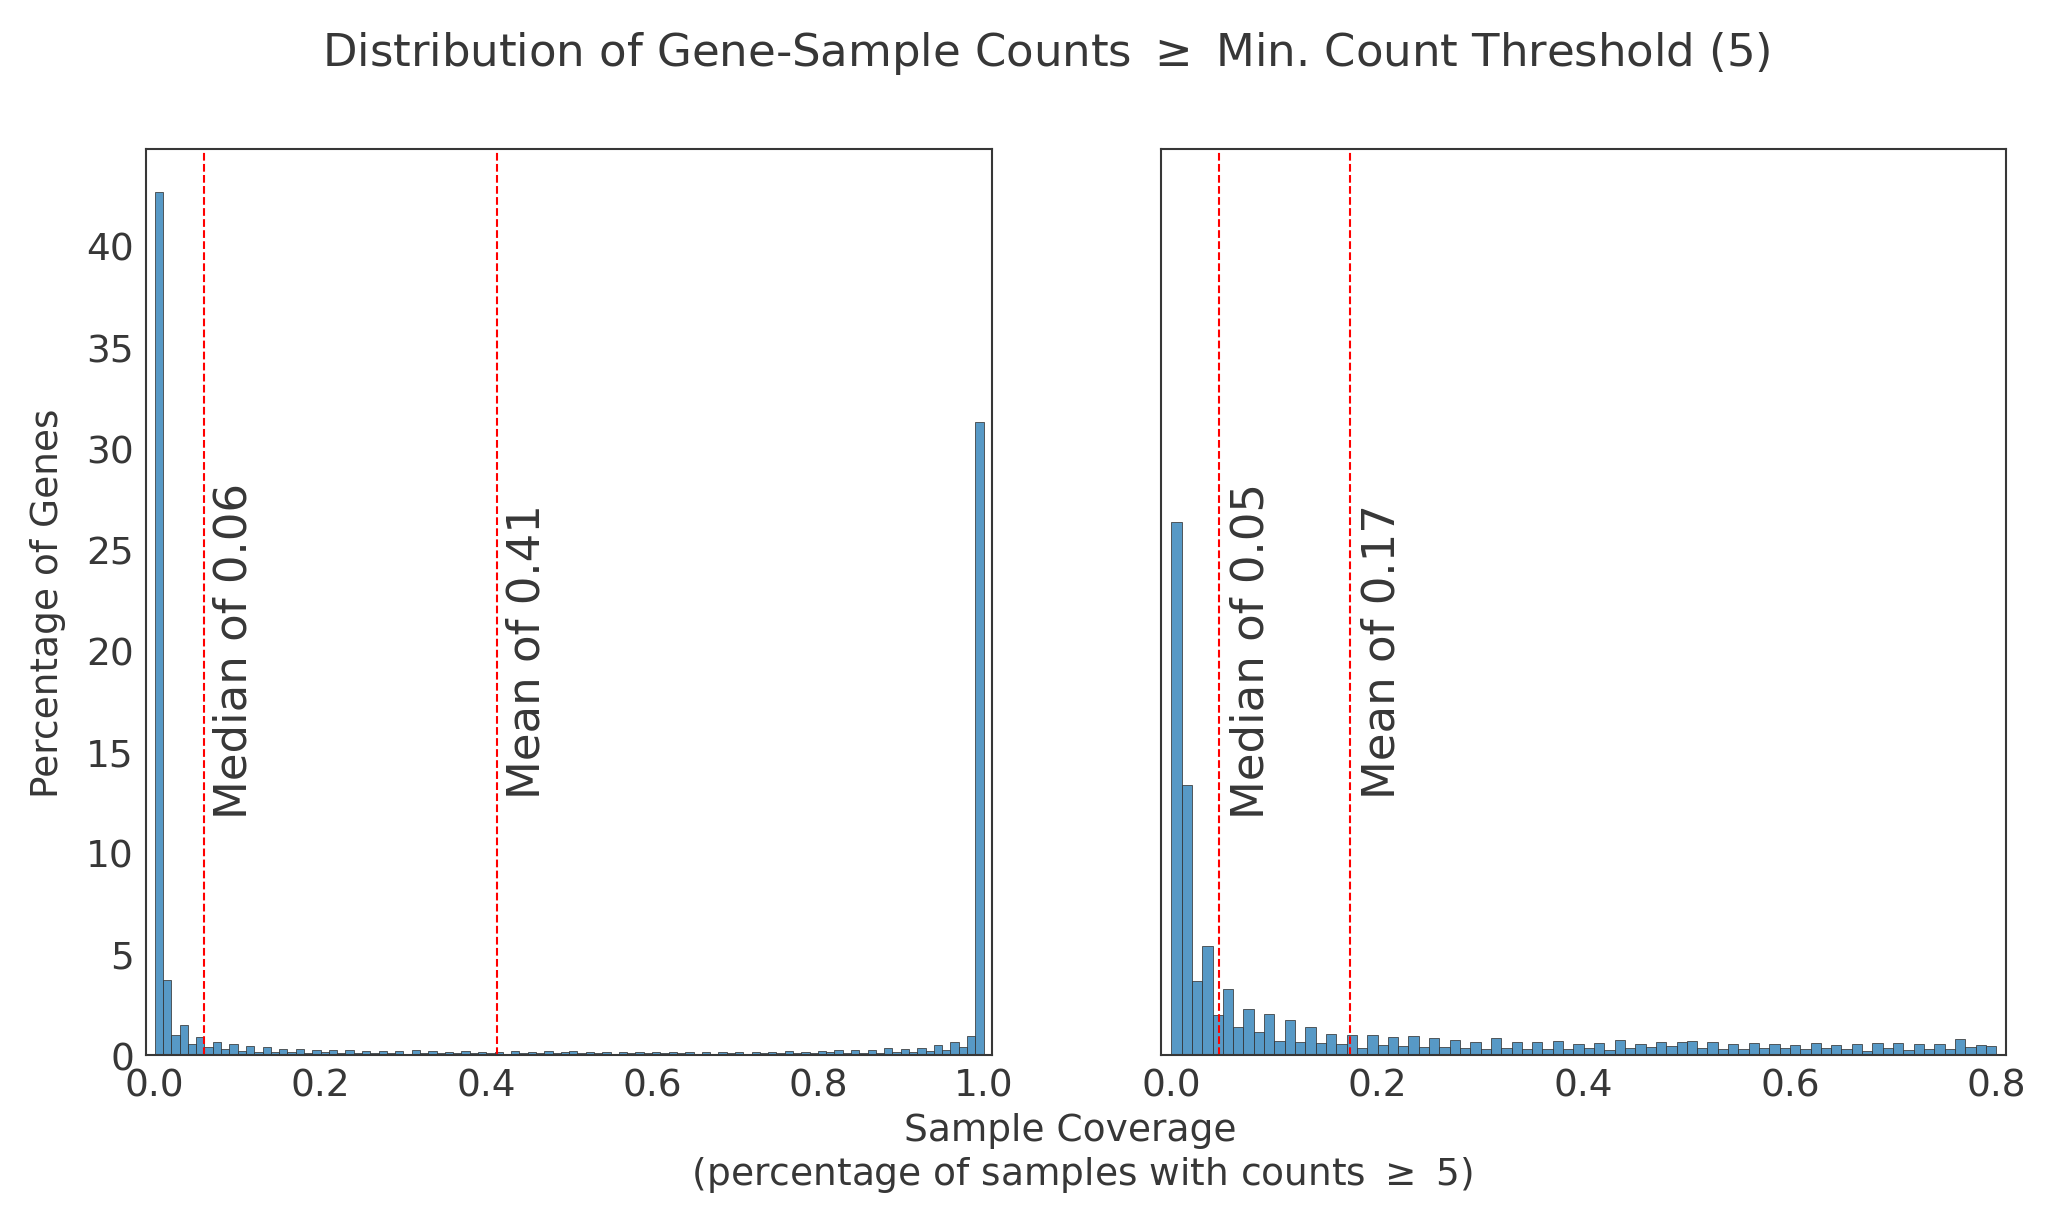

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True, dpi=300)
sns.histplot(min_count_percentage, stat='percent', binwidth=0.01, binrange=[0,1], ax=ax[0])
ax[0].set_xlim(left=-0.01,right=1.01)
mean_value = min_count_percentage.mean(); median_value = min_count_percentage.median()
ax[0].axvline(x=median_value, c="r", linestyle="--")
ax[0].axvline(x=mean_value, c="r", linestyle="--")
ax[0].text(median_value+0.01, 20, "Median of {:.2f}".format(median_value), rotation=90, verticalalignment='center', fontsize='large')
ax[0].text(mean_value+0.01, 20, "Mean of {:.2f}".format(mean_value), rotation=90, verticalalignment='center', fontsize='large')

sns.histplot(min_count_percentage[remainder_mask.values], stat='percent', binwidth=0.01, binrange=[0,1], ax=ax[1])
ax[1].set_xlim(left=-0.01,right=0.81)
mean_value = min_count_percentage[remainder_mask.values].mean(); median_value = min_count_percentage[remainder_mask.values].median()
ax[1].axvline(x=median_value, c="r", linestyle="--")
ax[1].axvline(x=mean_value, c="r", linestyle="--")
ax[1].text(median_value+0.01, 20, "Median of {:.2f}".format(median_value), rotation=90, verticalalignment='center', fontsize='large')
ax[1].text(mean_value+0.01, 20, "Mean of {:.2f}".format(mean_value), rotation=90, verticalalignment='center', fontsize='large')
# plt.xlim()
ax[0].set_ylabel('', fontsize=16); ax[1].set_ylabel('', fontsize=16)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Sample Coverage \n (percentage of samples with counts $\geq$ 5)")
plt.ylabel("Percentage of Genes")
plt.suptitle("Distribution of Gene-Sample Counts $\geq$ Min. Count Threshold (5)")

In [21]:
if generate_flat_files:
    pd.DataFrame(concat_df.loc[:,min_count_percentage >= 0.17].columns, columns=['ensemble_gene_id']).to_csv(p / "prefiltered_pseudogenes.csv", header=True)